
Copyright 2024 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.


# Activation Patching at Intervention Token

In [1]:
#@title Import libraries
import transformer_lens
import torch, gc, itertools, functools, tqdm, copy
import pandas as pd
import numpy as np
from typing import Callable

import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache
torch.set_grad_enabled(False)

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

#mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

import sys
sys.path.append('/home/jupyter/')
from paraMem.utils import modelHandlers, dataLoaders, patching

## Model

In [2]:
model = modelHandlers.load_model(model_type="gpt-neo-125M", DEVICE="cpu", lr=0.0, weight_decay=0.01)

Loaded pretrained model gpt-neo-125M into HookedTransformer
setting no_grad on ['embed', 'pos_embed', 'unembed', 'b_in', 'b_out', 'b_K', 'b_Q', 'b_V', 'b_O']


## Data

In [3]:
## load perturbed mem set and original mem set
mem_prompts, non_mem_prompts = dataLoaders.load_perturbed_mem(file_path="acc/gpt-neo-125M")
train_dl = torch.utils.data.DataLoader(list(zip(mem_prompts, non_mem_prompts)), batch_size=5, shuffle=False)
c_toks_NI, k_toks_NI = next(iter(train_dl))

### Identify Intervention and Impact Token

In [4]:
def get_interv_impact_indeces(c_toks_NI:torch.tensor, k_toks_NI:torch.tensor):
    """
    function to get the positions of the intervention (src) and impact (trg) token
    """
    ck_diff_mask = torch.where(c_toks_NI != k_toks_NI, 1,0)
    ck_diff_cumsum = torch.cumsum(ck_diff_mask, dim=-1) ## intervention

    ## find intervention
    src_NI = (ck_diff_cumsum==1).nonzero() 
    src_idcs = torch.cat((torch.zeros(1),(src_NI[:-1,0] != src_NI[1:,0]).nonzero(as_tuple=True)[0] + 1)).long()
    #src_NI = torch.sub(src_NI, torch.cat((torch.zeros(src_NI.shape[0],1),torch.ones(src_NI.shape[0],1)), dim=-1), alpha=1) ## -1 because we care about what token is predicted
    src_NI = src_NI[src_idcs].long() 

    ## find impact
    trg_NI = (ck_diff_cumsum==2).nonzero() 
    trg_NI_idcs = torch.cat((torch.zeros(1),(trg_NI[:-1,0] != trg_NI[1:,0]).nonzero(as_tuple=True)[0] + 1)).long()
    trg_NI = torch.sub(trg_NI, torch.cat((torch.zeros(trg_NI.shape[0],1),torch.ones(trg_NI.shape[0],1)), dim=-1), alpha=1) ## -1 because we care about what token is predicted
    trg_NI = trg_NI[trg_NI_idcs].long() 
    
    return src_NI, trg_NI

src_NI, trg_NI = get_interv_impact_indeces(c_toks_NI, k_toks_NI)

## Activation Patching

In [9]:
def patch_activs_fn(run_activs, hook: HookPoint, insert_activs:torch.tensor, tok_idcs:torch.tensor, head_idx:int=None):
    #print(f'patching {hook.name}')
    insert_activs = insert_activs[hook.name]
    if len(insert_activs.shape) == 4: ## pick attention head
        head_idcs = (torch.ones(tok_idcs.shape[0])*head_idx).long()
        run_activs[tok_idcs[:,0],tok_idcs[:,1],head_idcs] = insert_activs[tok_idcs[:,0],tok_idcs[:,1],head_idcs]
    else:
        run_activs[tok_idcs[:,0],tok_idcs[:,1]] = insert_activs[tok_idcs[:,0],tok_idcs[:,1]]
    return run_activs

def perform_intervention(run_toks:str, insert_activs:torch.FloatTensor, patch_activs_fn:Callable, tok_idcs:int, layer:int, c_type:str, head_idx:int=None):
    partial_patch_activs_fn = functools.partial(patch_activs_fn, insert_activs=insert_activs, tok_idcs=tok_idcs, head_idx=head_idx)
    layer_c_type = transformer_lens.utils.get_act_name(c_type, layer)
    patch_layers_fn = [(layer_c_type, partial_patch_activs_fn)]
    patched_logits = model.run_with_hooks(run_toks, fwd_hooks=patch_layers_fn,return_type="logits",reset_hooks_end=True)
    return patched_logits

def intervention_loop(model, clean_toks_NI:torch.tensor, pertubed_toks_NI:torch.tensor, src_NI:torch.tensor, trg_NI:torch.tensor, c_types:list):
    
    ## clean prompt__________________________
    clean_logits_NIT, clean_activs = model.run_with_cache(clean_toks_NI)    
    clean_nll_NI = modelHandlers.gather_token_scores(modelHandlers.NegLogLik(clean_logits_NIT.to("cpu")), clean_toks_NI)
    clean_cont_nll_NI = clean_nll_NI[trg_NI[:,0],trg_NI[:,1]]
    
    ## corrupted prompt______________________
    corrupted_logits_NIT, corrupted_activs = model.run_with_cache(pertubed_toks_NI)    
    corrupted_nll_NI = modelHandlers.gather_token_scores(modelHandlers.NegLogLik(corrupted_logits_NIT.to("cpu")), clean_toks_NI)
    corrupted_cont_nll_NI = corrupted_nll_NI[trg_NI[:,0],trg_NI[:,1]]
    
    print(f"mean: clean_nll_NI: {clean_nll_NI.mean(-1)}, corrupted_nll_NI {corrupted_nll_NI.mean(-1)}")
    print(f"clean_cont_nll_NI: {clean_cont_nll_NI}, corrupted_cont_nll_NI {corrupted_cont_nll_NI}")

    metric_res = list()#torch.zeros(model.cfg.n_layers, len(c_types))
    for i, layer in enumerate(tqdm.tqdm(range(1,model.cfg.n_layers-1))):
        layer_res = list()
        module_names = list()
        for j, c_type in enumerate(c_types):
            n_heads = 1
            if c_type in ["k", "q", "v", "z"]:
                n_heads = model.cfg.n_heads
            for head_idx in range(0, n_heads):
                if n_heads > 1:
                    module_names.append(f"{c_type} H{head_idx}")
                else:
                    module_names.append(f"{c_type}")
                
                ## (1) perform intervention
                patched_logits_NIT = perform_intervention(clean_toks_NI, corrupted_activs, patch_activs_fn, src_NI, layer, c_type, head_idx)

                ## (2) define intervention metrics
                patched_nll_NI = modelHandlers.gather_token_scores(modelHandlers.NegLogLik(patched_logits_NIT.to("cpu")), clean_toks_NI) ## get pred NLL
                patched_cont_nll_NI = patched_nll_NI[trg_NI[:,0],trg_NI[:,1]]

                #nll_change = (corrupted_cont_nll_NI.mean() - patched_cont_nll_NI.mean())
                nll_change = (patched_cont_nll_NI - clean_cont_nll_NI)#  / (patched_cont_nll_NI-corrupted_cont_nll_NI)
                nll_change = nll_change.mean()
                #metric_res[i,j] = nll_change
                
                layer_res.append(nll_change)
        metric_res.append(layer_res)
    return torch.tensor(metric_res), module_names

c_types= ["attn_out","mlp_out"] #"z","mlp_in", "q","k", "q","k","v","z","mlp_out"
metric_res, module_names = intervention_loop(model, c_toks_NI, k_toks_NI, src_NI, trg_NI, c_types)

mean: clean_nll_NI: tensor([0.7729, 0.2176, 0.3612, 1.2260, 0.7219]), corrupted_nll_NI tensor([7.9076, 7.8126, 7.5266, 6.8692, 7.7223])
clean_cont_nll_NI: tensor([8.5100e-02, -0.0000e+00, 1.1289e-03, 6.3190e+00, 1.3103e+00]), corrupted_cont_nll_NI tensor([14.1403,  3.3356,  4.0058,  6.7411,  1.2462])


100%|██████████| 10/10 [00:09<00:00,  1.05it/s]


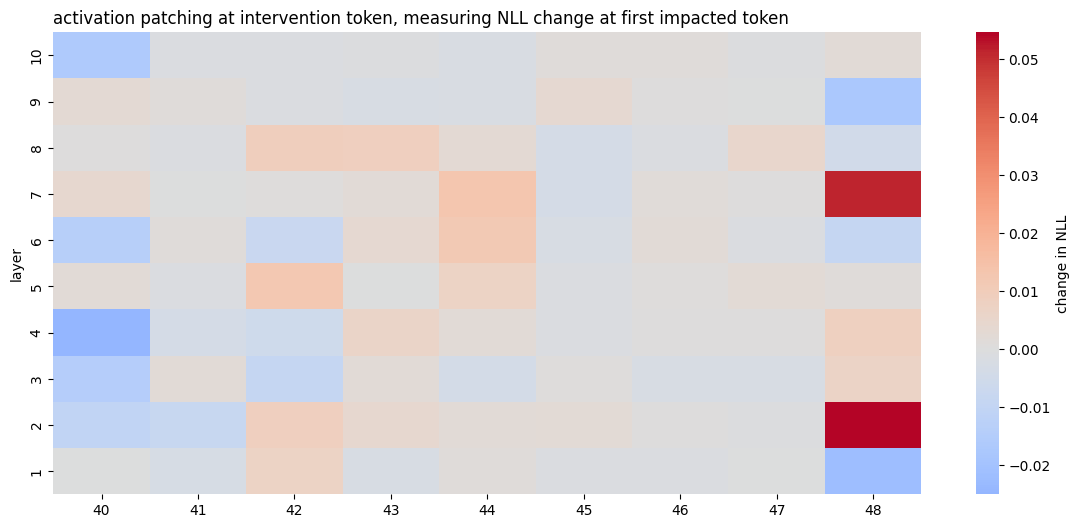

In [33]:
def plot_heatmap(vals:list, x_labels:list=None, y_labels:list=None, c_type:str=""):
    fig, ax = plt.subplots(1, 1, figsize=(14, 6), gridspec_kw={'hspace': 0.4})
    fontsize = 12
    ax = sns.heatmap(vals,
                  cmap=mpl.colormaps["coolwarm"], center=0, #coolwarm
                  xticklabels=x_labels,
                  yticklabels=y_labels, square=False, cbar_kws={'label': 'change in NLL'})
    ax.invert_yaxis()
    ax.set_ylabel("layer")
    ax.set_title(f"activation patching at intervention token, measuring NLL change at first impacted token", fontsize=fontsize, loc="left")

plot_heatmap(metric_res, x_labels=module_names, y_labels=np.arange(1,model.cfg.n_layers-1))